<a href="https://colab.research.google.com/github/LINYV0719/based_on_plantdoc_cnn_first_learning/blob/main/Diffusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! /opt/bin/nvidia-smi

Sat Dec 20 13:26:09 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   68C    P0             29W /   70W |    6640MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# 安装 Hugging Face 核心库
# diffusers: 扩散模型算法库
# transformers: 处理文本提示
# accelerate: 在单卡/多卡上进行混合精度训练
# datasets: 方便后续加载数据
!pip install -q diffusers transformers accelerate datasets

# 安装显存优化库
!pip install -q xformers

# 安装图像处理与评估库
# opencv-python: 用于图像切割和预处理
# torchmetrics: 用于计算PSNR,SSIM等指标
!pip install -q opencv-python matplotlib torchmetrics

# 安装torch2.9.0以及对应的vision和audio
!pip install torch==2.9.0 torchvision==0.24.0 torchaudio==2.9.0 xformers --index-url https://download.pytorch.org/whl/cu126

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.9/122.9 MB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 899.7/899.7 MB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 594.3/594.3 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 83.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.0/88.0 MB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 954.8/954.8 kB 67.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.1/193.1 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 63.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.6/63.6 MB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 267.5/267.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.2/288.2 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.3/39.3 MB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.

In [1]:
# 下载ControlNet训练脚本
!wget -q https://raw.githubusercontent.com/huggingface/diffusers/main/examples/controlnet/train_controlnet.py -O train_controlnet.py

# 创建accelerate的配置文件(强制开启fp16混合精度)
import yaml

accelerate_config = {
    "compute_environment": "LOCAL_MACHINE",
    "distributed_type": "NO",
    "mixed_precision": "fp16",
    "dynamo_backend": "no",
    "num_machines": 1,
    "num_processes": 1,
    "use_cpu": False
}

with open("accelerate_config.yaml", "w") as f:
    yaml.dump(accelerate_config, f)

print(" 训练脚本下载完成，加速配置已生成！")

 训练脚本下载完成，加速配置已生成！


In [3]:
# 安装最新版的diffusers以匹配训练脚本
!pip install -q git+https://github.com/huggingface/diffusers.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
import os

# 下载数据集到Colab本地环境
print("开始下载数据集...")
!git clone https://gitcode.com/open-source-toolkit/04615.git /content/cityscapes_raw

# 检查下载下来的文件夹里到底有什么
print("\n下载完成！让我们看看里面的结构：")
target_dir = "/content/cityscapes_raw"
if os.path.exists(target_dir):
    for root, dirs, files in os.walk(target_dir):
        level = root.replace(target_dir, '').count(os.sep)
        indent = ' ' * 4 * (level)
        print(f"{indent}{os.path.basename(root)}/")
        # 只显示前3个文件，避免刷屏
        subindent = ' ' * 4 * (level + 1)
        for f in files[:3]:
            print(f"{subindent}{f}")
        if len(files) > 3:
            print(f"{subindent}... (还有 {len(files)-3} 个文件)")
        # 只看两层目录，防止太长
        if level > 1:
            break
else:
    print("下载似乎失败了，请检查网络或链接。")

开始下载数据集...
fatal: destination path '/content/cityscapes_raw' already exists and is not an empty directory.

下载完成！让我们看看里面的结构：
cityscapes_raw/
    LICENSE
    README.md
    cityscapes.zip
    .git/
        config
        index
        description
        ... (还有 2 个文件)
        hooks/
            update.sample
            pre-rebase.sample
            prepare-commit-msg.sample
            ... (还有 10 个文件)


In [ ]:
import zipfile
import os

# 解压文件
zip_path = "/content/cityscapes_raw/cityscapes.zip"
extract_path = "/content/cityscapes_raw/unzipped"

print(f"正在解压 {zip_path} ...")
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)
print("解压完成！")

# 寻找图片所在的文件夹路径
print("\n正在寻找图片路径...")
found_source_path = None

for root, dirs, files in os.walk(extract_path):
    # 检查这一层有没有jpg图片
    jpg_files = [f for f in files if f.endswith('.jpg') or f.endswith('.png')]
    if len(jpg_files) > 0:
        print(f"在文件夹: {root}")
        print(f"包含图片数量: {len(jpg_files)}")
        print(f"样例图片: {jpg_files[:3]}")
        found_source_path = root
        break # 找到第一个包含图片的文件夹就停止

if found_source_path:
    print(f"\n请记下这个路径，这是SOURCE_PATH: \n{found_source_path}")
else:
    print("解压后的文件夹里没有图片？请检查压缩包内容。")

正在解压 /content/cityscapes_raw/cityscapes.zip ...
解压完成！

正在寻找图片路径...
在文件夹: /content/cityscapes_raw/unzipped/cityscapes/train
包含图片数量: 2975
样例图片: ['308.jpg', '1097.jpg', '132.jpg']

请记下这个路径，这是SOURCE_PATH: 
/content/cityscapes_raw/unzipped/cityscapes/train


In [ ]:
import os
import cv2
import json
from tqdm import tqdm

SOURCE_PATH = "/content/cityscapes_raw/unzipped/cityscapes/train"
# 输出路径保持在 Drive，这样下次不用重跑
OUTPUT_PATH = "/content/drive/MyDrive/cityscapes_processed"

# 确保输出目录存在
os.makedirs(f"{OUTPUT_PATH}/images", exist_ok=True)
os.makedirs(f"{OUTPUT_PATH}/conditioning_images", exist_ok=True)

def process_data_final(source_dir, output_dir):
    json_lines = []

    # 获取所有图片文件
    if not os.path.exists(source_dir):
        print(f"错误：路径不存在 {source_dir}")
        return

    image_files = [f for f in os.listdir(source_dir) if f.endswith(('.jpg', '.png'))]
    print(f" 准备处理 {len(image_files)} 张图片...")

    for img_name in tqdm(image_files):
        img_path = os.path.join(source_dir, img_name)
        img = cv2.imread(img_path)

        if img is None: continue

        # 切割图片
        h, w, c = img.shape
        real_img = img[:, :w//2]      # 左半边: 真实街景
        semantic_img = img[:, w//2:]  # 右半边: 语义标签

        # 调整大小
        real_img = cv2.resize(real_img, (512, 512))
        semantic_img = cv2.resize(semantic_img, (512, 512))

        # 保存图片
        cv2.imwrite(f"{output_dir}/images/{img_name}", real_img)
        cv2.imwrite(f"{output_dir}/conditioning_images/{img_name}", semantic_img)

        # 记录索引
        json_lines.append({
            "text": "a high quality photo of a city street",
            "image": f"images/{img_name}",
            "conditioning_image": f"conditioning_images/{img_name}"
        })

    # 保存为metadata.jsonl
    with open(f"{output_dir}/metadata.jsonl", 'w') as f:
        for line in json_lines:
            f.write(json.dumps(line) + "\n")

    print(f"\n数据处理完毕！索引文件已生成于: {output_dir}/metadata.jsonl")

# 运行处理
process_data_final(SOURCE_PATH, OUTPUT_PATH)

 准备处理 2975 张图片...


100%|██████████| 2975/2975 [01:27<00:00, 34.02it/s]


数据处理完毕！索引文件已生成于: /content/drive/MyDrive/cityscapes_processed/metadata.jsonl


In [ ]:
# 确认验证图片路径
VALIDATION_IMG = "/content/drive/MyDrive/cityscapes_processed/conditioning_images/308.jpg"

# 启动训练
!accelerate launch --config_file accelerate_config.yaml train_controlnet.py \
 --pretrained_model_name_or_path="runwayml/stable-diffusion-v1-5" \
 --output_dir="/content/drive/MyDrive/controlnet_cityscapes_model" \
 --train_data_dir="/content/drive/MyDrive/cityscapes_processed" \
 --resolution=512 \
 --learning_rate=1e-5 \
 --image_column="image" \
 --caption_column="text" \
 --conditioning_image_column="conditioning_image" \
 --validation_image="$VALIDATION_IMG" \
 --validation_prompt "a high quality photo of a city street" \
 --train_batch_size=4 \
 --gradient_accumulation_steps=4 \
 --mixed_precision="fp16" \
 --enable_xformers_memory_efficient_attention \
 --checkpointing_steps=500 \
 --validation_steps=100 \
 --max_train_steps=1000

2025-12-20 10:33:15.564504: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1766226795.589098   28197 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1766226795.596081   28197 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1766226795.615121   28197 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1766226795.615189   28197 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1766226795.615194   28197 computation_placer.cc:177] computation placer alr

正在生成 3 组对比图，请稍候...


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

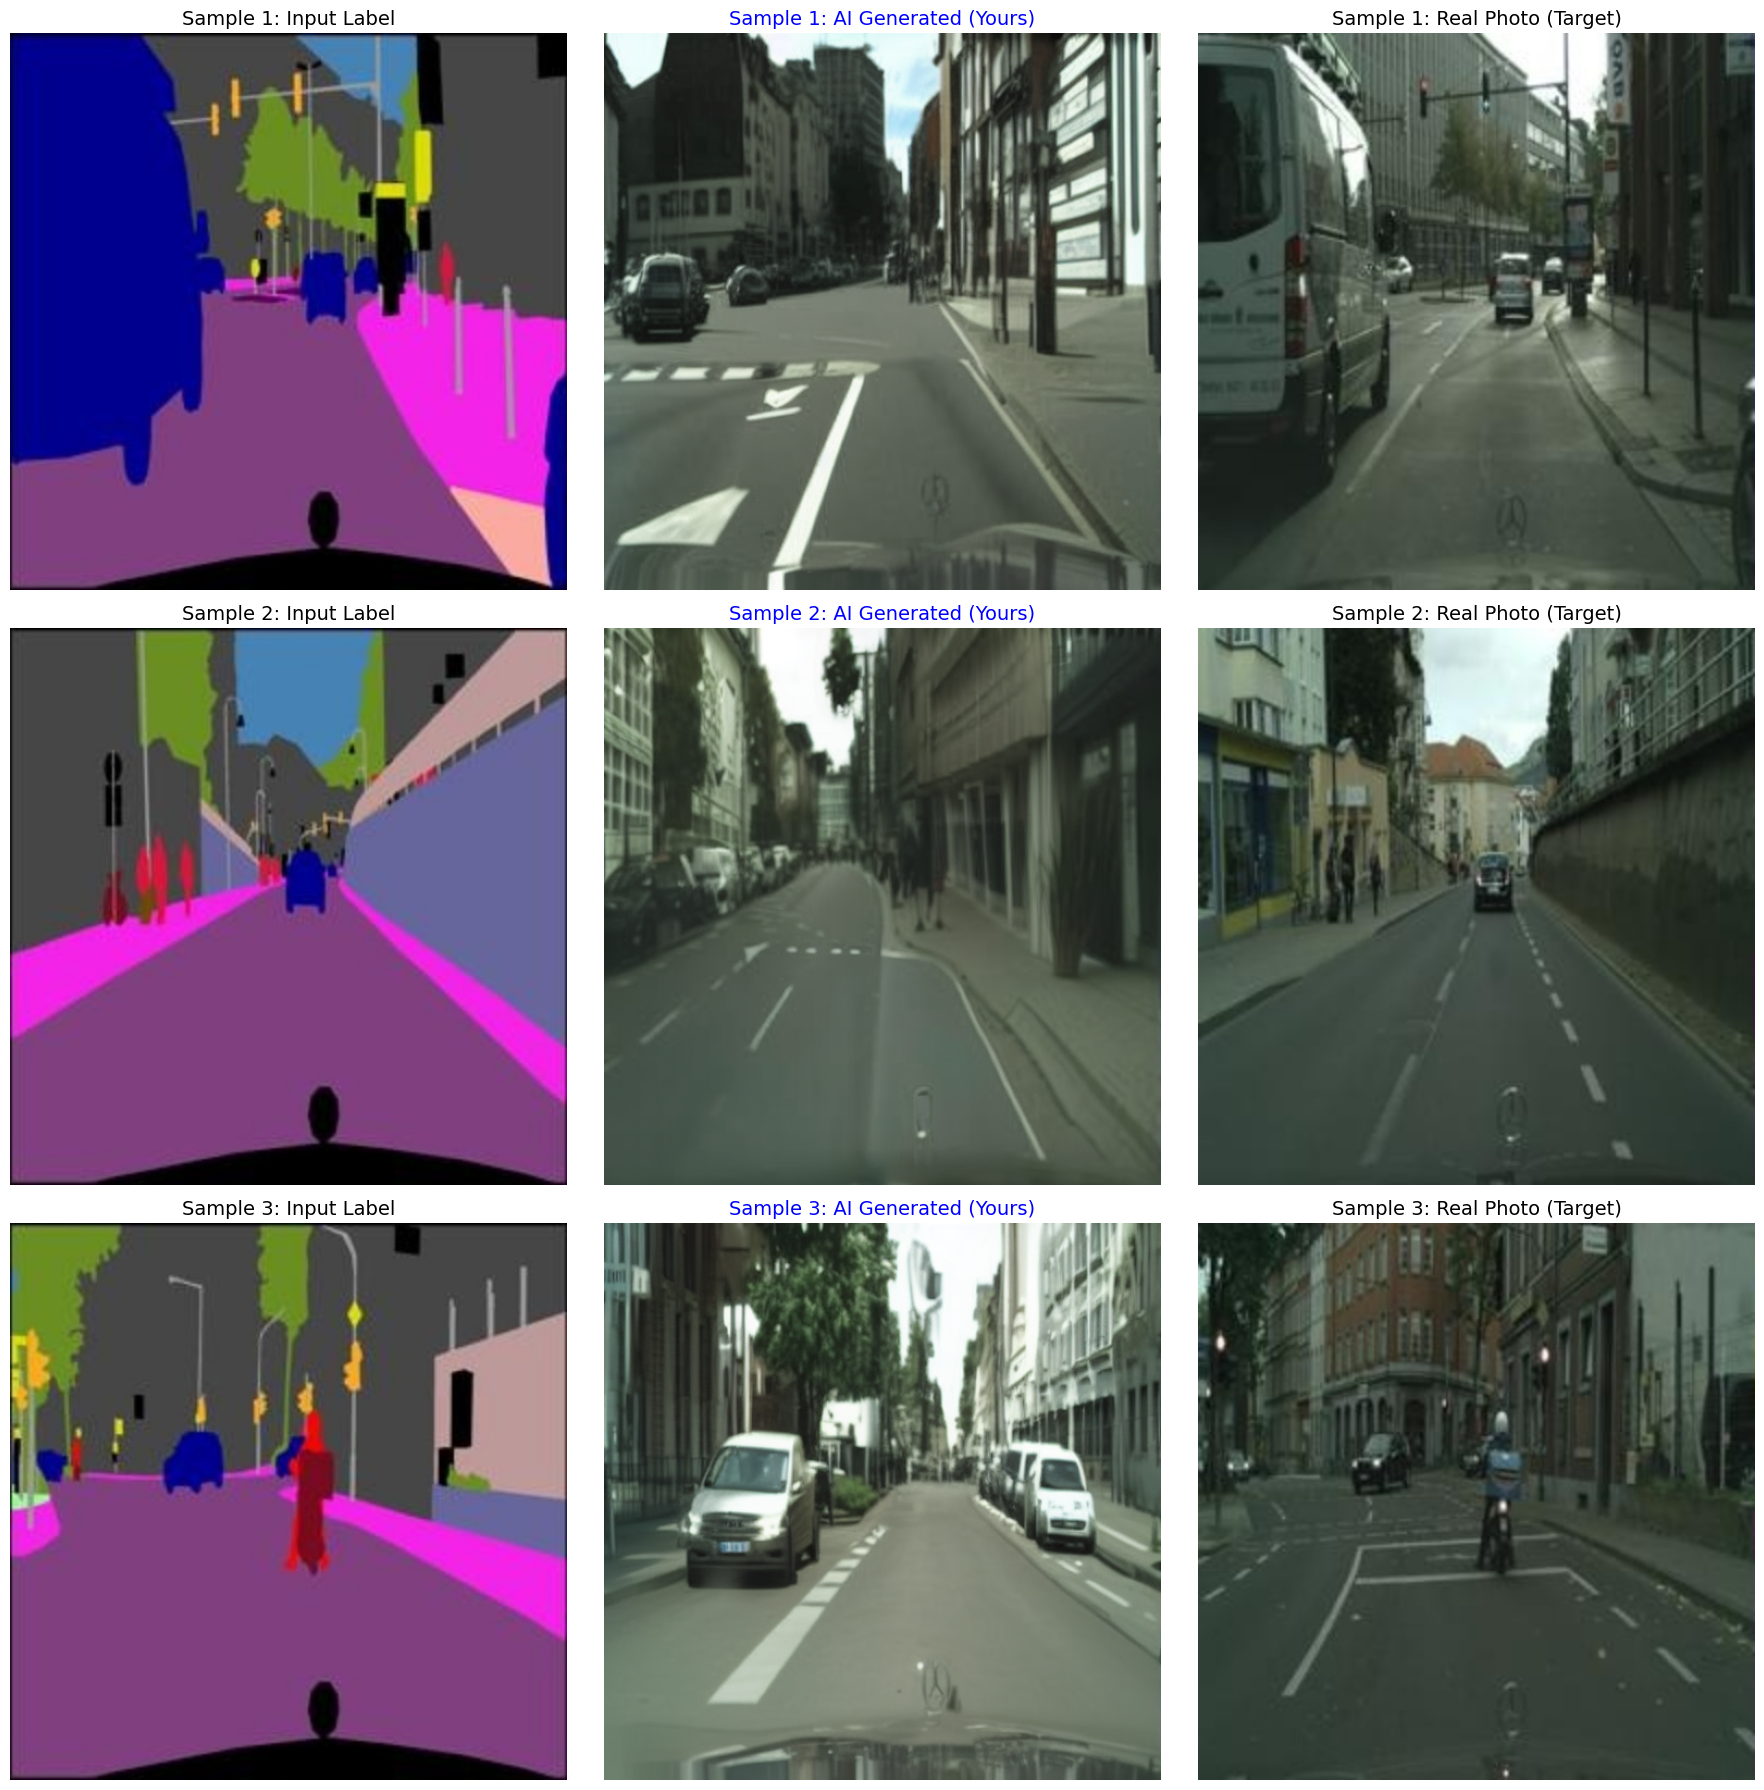

In [2]:
import matplotlib.pyplot as plt
import os
import random
import glob
from diffusers.utils import load_image
import torch

def show_triplets(num_samples=3):
    # 准备路径
    data_dir = "/content/drive/MyDrive/cityscapes_processed"
    cond_imgs_dir = os.path.join(data_dir, "conditioning_images")
    target_imgs_dir = os.path.join(data_dir, "images")

    # 随机抽取样本
    all_cond_files = glob.glob(os.path.join(cond_imgs_dir, "*.jpg"))
    if len(all_cond_files) == 0:
        print("错误：找不到测试图片，请检查路径。")
        return

    sample_files = random.sample(all_cond_files, num_samples)

    # 设置画板(行数=样本数,列数=3)
    plt.figure(figsize=(18, 6 * num_samples))

    print(f"正在生成 {num_samples} 组对比图，请稍候...")

    for i, cond_path in enumerate(sample_files):
        #准备数据
        filename = os.path.basename(cond_path)
        target_path = os.path.join(target_imgs_dir, filename)

        #加载语义图
        control_image = load_image(cond_path)

        #加载真实图
        if os.path.exists(target_path):
            ground_truth = load_image(target_path)
        else:
            print(f"警告: 找不到对应的真实图 {filename}")
            from PIL import Image
            ground_truth = Image.new("RGB", (512, 512), "black")

        # 模型生成
        # 这里的seed不固定，看看模型发挥
        with torch.no_grad():
            generated_image = pipe(
                "a high quality photo of a city street",
                num_inference_steps=20,
                image=control_image,
                controlnet_conditioning_scale=1.0 # 满强度控制
            ).images[0]

        # 绘图 (左中右布局)
        # 左图：语义分割图
        ax = plt.subplot(num_samples, 3, i * 3 + 1)
        plt.imshow(control_image)
        plt.title(f"Sample {i+1}: Input Label", fontsize=14)
        plt.axis("off")

        # 中图：你的模型生成的
        ax = plt.subplot(num_samples, 3, i * 3 + 2)
        plt.imshow(generated_image)
        plt.title(f"Sample {i+1}: AI Generated (Yours)", fontsize=14, color="blue")
        plt.axis("off")

        # 右图：真实参考图
        ax = plt.subplot(num_samples, 3, i * 3 + 3)
        plt.imshow(ground_truth)
        plt.title(f"Sample {i+1}: Real Photo (Target)", fontsize=14)
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# 运行可视化
show_triplets(num_samples=3)

找到日志文件: /content/drive/MyDrive/controlnet_cityscapes_model/logs/train_controlnet/events.out.tfevents.1766226255.071bcc582f22.25373.0
正在解析日志数据，可能需要一点时间...


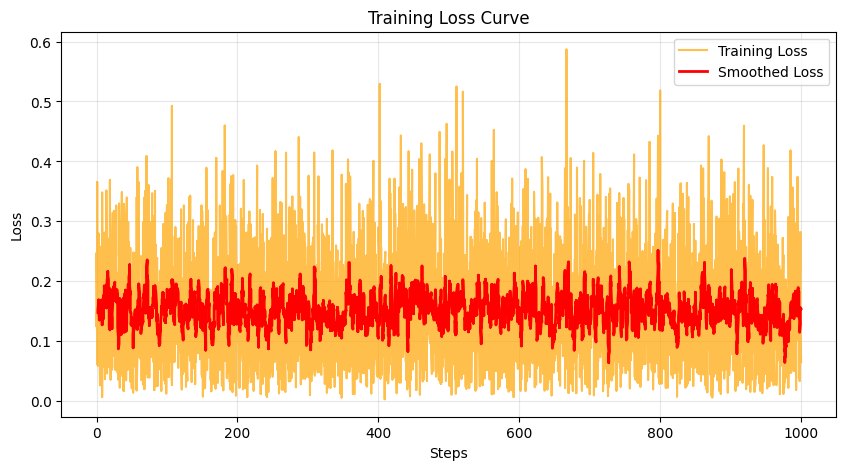

In [5]:
import os
import matplotlib.pyplot as plt
from tensorflow.python.summary.summary_iterator import summary_iterator
import glob

# ================= 配置 =================
log_dir = "/content/drive/MyDrive/controlnet_cityscapes_model"

# ================= 绘图逻辑 =================
def plot_training_loss(log_dir):
    # 寻找 TensorBoard 日志文件
    search_pattern = os.path.join(log_dir, "**", "events.out.tfevents*")
    event_files = glob.glob(search_pattern, recursive=True)

    if not event_files:
        print("未找到日志文件！可能原因：")
        print("训练时未开启TensorBoard")
        print("路径错误。")
        return

    print(f"找到日志文件: {event_files[0]}")

    steps = []
    losses = []

    # 解析日志
    try:
        # 遍历最新的日志文件
        latest_file = max(event_files, key=os.path.getctime)
        print("正在解析日志数据，可能需要一点时间...")

        for e in summary_iterator(latest_file):
            for v in e.summary.value:
                if v.tag == "train/loss" or v.tag == "loss":
                    steps.append(e.step)
                    losses.append(v.simple_value)

    except Exception as e:
        print(f" 解析出错: {e}")
        return

    if not steps:
        print(" 日志里没有找到 loss 数据。")
        return

    # 绘制曲线
    plt.figure(figsize=(10, 5))
    plt.plot(steps, losses, label="Training Loss", color="orange", alpha=0.7)

    # 平滑曲线(Moving Average)以便观察趋势
    if len(losses) > 20:
        window_size = 10
        import numpy as np
        smoothed_loss = np.convolve(losses, np.ones(window_size)/window_size, mode='valid')
        plt.plot(steps[window_size-1:], smoothed_loss, label="Smoothed Loss", color="red", linewidth=2)

    plt.xlabel("Steps")
    plt.ylabel("Loss")
    plt.title("Training Loss Curve")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

# 运行绘图
plot_training_loss(log_dir)

In [15]:
!pip install -q torch-fidelity torchmetrics

In [2]:
import torch
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel, UniPCMultistepScheduler
from torchmetrics.image.fid import FrechetInceptionDistance
from torchmetrics.image import PeakSignalNoiseRatio, StructuralSimilarityIndexMeasure
from torchmetrics import MeanAbsoluteError
from torchvision import transforms
from diffusers.utils import load_image
import os
import glob
from google.colab import drive

# ================= 挂载与环境准备 =================
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"使用设备: {device}")

# ================= 加载模型 (自动判断是否需要加载) =================
# 配置路径 (根据你的实际情况)
controlnet_path = "/content/drive/MyDrive/controlnet_cityscapes_model"
base_model_path = "runwayml/stable-diffusion-v1-5"

if 'pipe' not in globals():
    print("正在从 Drive 加载模型...")
    try:
        controlnet = ControlNetModel.from_pretrained(controlnet_path, torch_dtype=torch.float16)
        pipe = StableDiffusionControlNetPipeline.from_pretrained(
            base_model_path, controlnet=controlnet, torch_dtype=torch.float16, safety_checker=None
        ).to(device)
        pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)
        pipe.enable_xformers_memory_efficient_attention()
        print("模型加载成功！")
    except Exception as e:
        print(f"模型加载失败，请检查路径: {e}")
        # 如果加载失败，下面的代码会报错，所以停止运行
        raise e

# ================= 定义评估函数 =================
# 初始化指标
print("初始化指标计算器 (首次运行需要下载 Inception 模型)...")
fid_metric = FrechetInceptionDistance(feature=64).to(device)
psnr_metric = PeakSignalNoiseRatio(data_range=1.0).to(device)
ssim_metric = StructuralSimilarityIndexMeasure(data_range=1.0).to(device)
mae_metric = MeanAbsoluteError().to(device)

transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
])

def evaluate_final(num_test=30):
    data_dir = "/content/drive/MyDrive/cityscapes_processed"
    cond_imgs_dir = os.path.join(data_dir, "conditioning_images")
    target_imgs_dir = os.path.join(data_dir, "images")

    all_cond_files = glob.glob(os.path.join(cond_imgs_dir, "*.jpg"))
    test_files = all_cond_files[:num_test]

    print(f"开始评估 {len(test_files)} 张图片...")
    fid_metric.reset()
    total_psnr, total_ssim, total_mae = [], [], []

    for i, cond_path in enumerate(test_files):
        filename = os.path.basename(cond_path)
        target_path = os.path.join(target_imgs_dir, filename)
        if not os.path.exists(target_path): continue

        # 加载与生成
        control = load_image(cond_path)
        gt = load_image(target_path).resize((512, 512))

        with torch.no_grad():
            gen = pipe("a high quality photo of a city street", num_inference_steps=20, image=control, output_type="pil").images[0]

        # 数据转换
        pred_t = transform(gen).unsqueeze(0).to(device)
        target_t = transform(gt).unsqueeze(0).to(device)

        # 这里的关键：FID 需要 uint8 (0-255)
        pred_uint8 = (pred_t * 255).to(torch.uint8)
        target_uint8 = (target_t * 255).to(torch.uint8)

        # 更新指标
        total_psnr.append(psnr_metric(pred_t, target_t).item())
        total_ssim.append(ssim_metric(pred_t, target_t).item())
        total_mae.append(mae_metric(pred_t, target_t).item())

        fid_metric.update(target_uint8, real=True)
        fid_metric.update(pred_uint8, real=False)

        if (i+1) % 5 == 0: print(f"   已处理 {i+1}/{num_test}...")

    print("\n正在计算 FID...")
    fid_score = fid_metric.compute().item()

    print("\n=========  最终评估结果 =========")
    print(f"FID  : {fid_score:.4f}")
    print(f"PSNR : {sum(total_psnr)/len(total_psnr):.4f}")
    print(f"SSIM : {sum(total_ssim)/len(total_ssim):.4f}")
    print(f"MAE  : {sum(total_mae)/len(total_mae):.4f}")
    print("===================================")

# ================= 执行 =================
evaluate_final(num_test=50)

Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.
Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.


使用设备: cuda
正在从 Drive 加载模型...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

`torch_dtype` is deprecated! Use `dtype` instead!
You have disabled the safety checker for <class 'diffusers.pipelines.controlnet.pipeline_controlnet.StableDiffusionControlNetPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


模型加载成功！
初始化指标计算器 (首次运行需要下载 Inception 模型)...
开始评估 50 张图片...


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

   已处理 5/50...


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

   已处理 10/50...


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

   已处理 15/50...


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

   已处理 20/50...


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

   已处理 25/50...


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

   已处理 30/50...


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

   已处理 35/50...


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

   已处理 40/50...


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

   已处理 45/50...


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

   已处理 50/50...

正在计算 FID...

=========  最终评估结果 =========
FID  : 1.3574
PSNR : 11.6838
SSIM : 0.4518
MAE  : 0.2035
